# Car Prediction

Using k-nearest neighbors, we're trying to predict the pricing of the car based on well-known features

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

%matplotlib inline

#print(cars.columns)
#cars.dtypes
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv("imports-85.data",names=cols)
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [10]:
#replacing "?" data into numeric for training
#Changing datatypes for numeric values/continuous values
#https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names
#only selecting values for Linear Regression

cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
new_cars = cars[cols]
new_cars = new_cars.replace("?",np.nan)
new_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,NaN,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,13495
1,NaN,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,16500
2,NaN,94.5,171.2,65.5,52.4,2823,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,3.19,3.40,8.0,115,5500,18,22,17450


In [11]:
#we're replacing all the missing data with average values
new_cars = new_cars.astype(float) #we already filtered out numeric columns
avg_norm_losses = new_cars['normalized-losses'].mean()
#avg_norm_losses
new_cars['normalized-losses'].replace(np.nan, avg_norm_losses,inplace=True)
new_cars.head()
new_cars['normalized-losses'].isnull().sum()

0

In [12]:
#follow the same logic for other columns
cols = new_cars.columns.tolist()
for col in cols:
    if new_cars[col].isnull().sum()  > 0:
        avg = new_cars[col].mean()
        new_cars[col].replace(np.nan,avg,inplace=True)
new_cars.isnull().sum() #woot!

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

In [13]:
#normalize all columns but the price column (min-max normalization)
cols = new_cars.columns.tolist()
cols.remove("price")
cols

for col in cols:
    max_ = new_cars[col].max()
    min_ = new_cars[col].min()
    mean_ = new_cars[col].mean()
    new_cars[col] = (new_cars[col] - mean_)/(max_ - min_)
new_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.000000,-0.296110,-0.078347,-0.150650,-0.410407,-0.002935,0.100178,-0.274011,-0.071409,0.028099,-0.051171,-0.117209,-0.098716,13495.0
1,0.000000,-0.296110,-0.078347,-0.150650,-0.410407,-0.002935,0.100178,-0.274011,-0.071409,0.028099,-0.051171,-0.117209,-0.098716,16500.0
2,0.000000,-0.124099,-0.042526,-0.033984,-0.110407,0.103737,-0.464108,0.102180,-0.071409,0.207266,-0.051171,-0.172764,-0.125032,16500.0
3,0.219895,0.030420,0.038071,0.024350,0.047927,-0.084781,-0.099822,0.068846,-0.008909,-0.009401,0.152910,-0.033875,-0.019769,13950.0
4,0.219895,0.018758,0.038071,0.041016,0.047927,0.104125,-0.099822,0.068846,-0.133909,0.044766,0.152910,-0.200542,-0.230295,17450.0


In [14]:
def knn_train_test(k_num,train_col,target_col,df):
    seed = np.random.seed(1)
    shuffle = np.random.permutation(df.index)
    df_new = df.reindex(shuffle)
    divider = int(len(df)*0.75)
    
    train_set = df.iloc[0:divider]
    test_set = df.iloc[divider:]
    
    knn = KNeighborsRegressor(n_neighbors=k_num,algorithm='auto')
    knn.fit(train_set[train_col],train_set[target_col])
    hypothesis = knn.predict(test_set[train_col])
    mse = mean_squared_error(test_set[target_col],hypothesis)
    return mse**0.5 #rmse

knn = knn_train_test(10,['horsepower','highway-mpg'],['price'],new_cars)
knn

2353.381880478646

Text(0.5,0,'k-value')

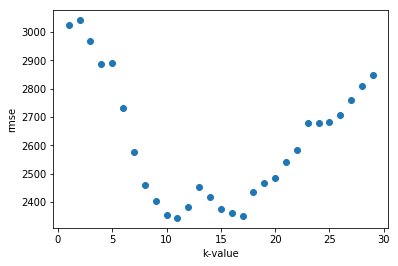

In [18]:
#testing out different k-values, plotting the loss function against k
rmse = list()
for i in range(1,30):
    result = knn_train_test(i,['horsepower','highway-mpg'],['price'],new_cars)
    rmse.append(result)
rmse
plt.scatter(range(1,30),rmse)
plt.ylabel("rmse")
plt.xlabel("k-value")
#seems like we have 2 good local min at 11 and 17

It seems that we have a double minimum valleys here. In theory, 11 and 17 would be ok. Before that, we have underfitting. After that, we have overfitting.

Text(0.5,0,'k-value')

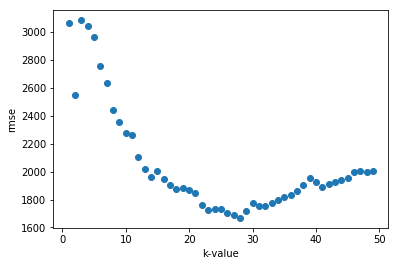

In [20]:
#more columns (all columns)
rmse = list()
for i in range(1,50):
    result = knn_train_test(i,cols,['price'],new_cars)
    rmse.append(result)
rmse
plt.scatter(range(1,50),rmse)
plt.ylabel("rmse")
plt.xlabel("k-value")
#we look to be able to reach a min value of ~$1600 error with all parameters
#Generally, more parameters = better but not neccessarily always. Obviously it's still better than previous model

In [22]:
#prevent too much overfitting
#modifying our train function to include cross validation
#n_split for cv validation, k_num for # of k-clusters, train_col = features, target_col = results column,
#df = dataframe
def knn_train_test2(n_split,k_num,train_col,target_col,df):
    seed = np.random.seed(1)
    kf = KFold(n_splits=n_split,shuffle=True,random_state=1)
    shuffle = np.random.permutation(df.index)
    df_new = df.reindex(shuffle)
    divider = int(len(df)*0.75)
    
    train_set = df.iloc[0:divider]
    test_set = df.iloc[divider:]
    
    knn = KNeighborsRegressor(n_neighbors=k_num,algorithm='auto')
    #knn.fit(train_set[train_col],train_set[target_col])
    mses = cross_val_score(knn,df[train_col],df[target_col],
	scoring="neg_mean_squared_error",cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    rmse = np.mean(rmses)
    #hypothesis = knn.predict(test_set[train_col])
    #mse = mean_squared_error(test_set[target_col],hypothesis)
    return  rmse

knn = knn_train_test2(4,10,['horsepower','highway-mpg'],['price'],new_cars)
knn


3811.0457726512686

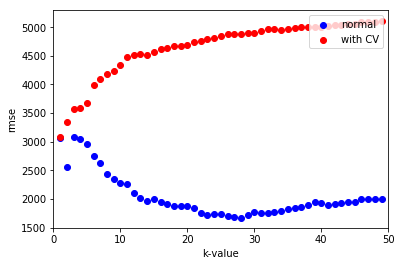

7868.7682123438


In [25]:
rmse = list() #normal
rmse_2 = list() #with cross validation
for i in range(1,50):
    result = knn_train_test(i,cols,['price'],new_cars)
    result2 = knn_train_test2(10,i,cols,['price'],new_cars)
    rmse.append(result)
    rmse_2.append(result2)
rmse
plt.close()
plt.scatter(range(1,50),rmse,c='b') 
plt.scatter(range(1,50),rmse_2,c='r')
plt.xlim(0,50)
plt.legend(["normal","with CV"],loc="upper right")
plt.ylabel("rmse")
plt.xlabel("k-value")
plt.show()
print(new_cars["price"].std())
#is the divergence real? Error is still within 1 std of the price column. There is no local minum seen in the CV function.


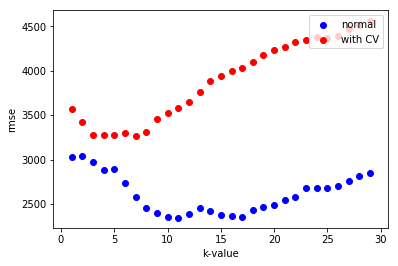

In [27]:
#we know that 2 parameters: ['horsepower','highway-mpg'] affects the price point, let's test out with the cv
cols = ['horsepower','highway-mpg']
rmse = list()
rmse_2 = list()
for i in range(1,30):
    result = knn_train_test(i,cols,['price'],new_cars)
    result2 = knn_train_test2(20,i,cols,['price'],new_cars)
    rmse.append(result)
    rmse_2.append(result2)
    
plt.scatter(range(1,30),rmse,c='b')
plt.scatter(range(1,30),rmse_2,c='r')
plt.legend(["normal","with CV"],loc="upper right")
plt.ylabel("rmse")
plt.xlabel("k-value")
plt.show()
#playing around with the cv splits does help a bit with the full divergence problem.


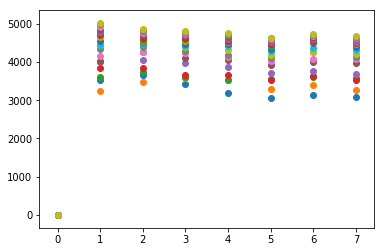

In [28]:
cols = new_cars.columns.tolist()
cols.remove('price')
def cv_matrix(n_split, k_num,cols,target,df):
    result = dict() #key= k_num, val=(n_split,error)
    for k in range(1,k_num):
        for n in range(2,n_split):
            rmse = knn_train_test2(n,k,cols,target,df)
            if k not in result:
                result[k] = [0]
            else:
                result[k].append(rmse)
    return result

knn_cv = cv_matrix(10,20,cols,['price'],new_cars)
#knn_cv        

for k in knn_cv:
    #zero point is just the holder
    plt.scatter(range(0,len(knn_cv[k])),knn_cv[k])
    #plt.legend(knn_cv)

    
plt.show()
#need to separate the plots later.